
## Dell Technical Support Email Classification: A Deep Dive


_by Cian Prendergast_

### **Introduction**

This is an old project but, seeing how a lot of ULMFiT tecniques are being redicovered, I thought I'd share it! 

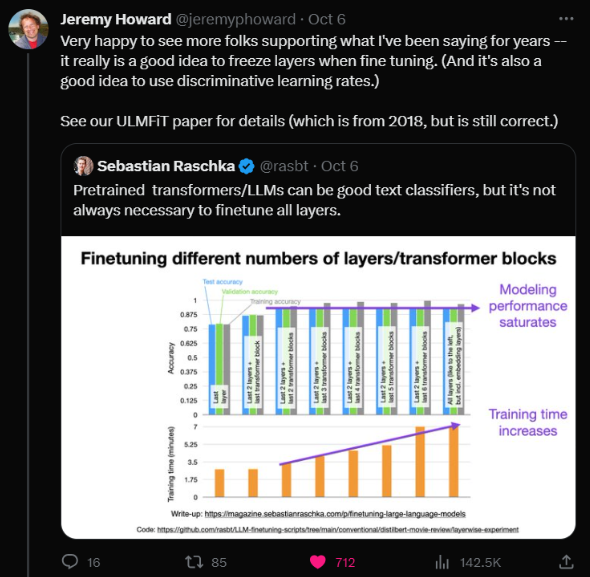

Its essentially the [older fastai NLP lesson](https://github.com/fastai/fastbook/blob/master/10_nlp.ipynb) from fastai course/book. ULMFit is both a training method and a type of model, where the model is tasked with predicting the next word in a sentence, and through this process learns about world concepts.

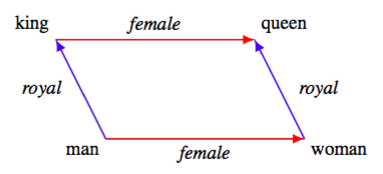

Transformers like BERT (Bidirectional Encoder Representations from Transformers), don't allow for this "predict the next word" method, instead they delete a word at random (mask it from the model) and ask the model to predict the deleted words. Other then that the concepts between ULMFiT and Transormers are essentially [the same](https://www.youtube.com/watch?v=toUgBQv1BT8).


This project is phrased as a binary classification problem, the model is tasked to classify Dell Technical Support emails into 'software' or 'hardware' categories. Sourced from an in-house case scraping tool at Dell, we have a dataset comprising 1324 emails. Of these, 662 are labeled as software-related ('sw') and 662 as hardware-related ('hw'). This labeling was done based on the domain knowledge of the researchers, and the data is stored in a CSV file with each email occupying one row.

The approach we've taken in this notebook is based on [ULMFiT method](https://paperswithcode.com/method/ulmfit#:~:text=Universal%20Language%20Model%20Fine%2Dtuning,-Introduced%20by%20Howard&text=It%20involves%20a%203%2Dlayer%20AWD%2DLSTM%20architecture%20for%20its,classifier%20on%20the%20target%20task.). We start with a pretrained language model, Wikitext103, which is already proficient in understanding the structure of the English language. This model is then tasked to predict whether a given email pertains to 'sw' or 'hw'. 

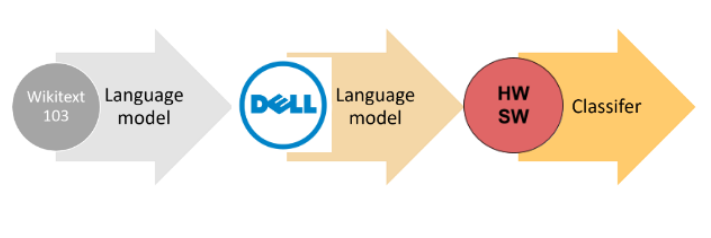

But how do we feed these emails to the model? They undergo tokenization, where sentences are split into individual words. Additionally, to ensure each batch fed to the model is of uniform size, we utilize special tokens. For shorter emails, padding is done using a reserved token termed `xxunk`. This process also involves numericalizing the words to form a vocabulary, prioritizing words based on their frequency of occurrence.

Yet, there's always room for improvement. We further train our own language model tailored to Dell-specific vocabulary, built upon the LSTM architecture. This model is trained to predict subsequent words in a sentence.

Lastly, we retrain our newly minted language model to classify the emails. We gradually unfreeze each layer, aiming for enhanced performance.



---

Now, let's extract the content related to the dataset and see how it's structured.

### **Dataset**

Before diving into the intricacies of our model, it's essential to get a firsthand look at the dataset we're dealing with.

The dataset is imported from a CSV file, and here's how we load it into a Pandas dataframe:

```python
df = pd.read_csv('Dataset_CSV.csv')
```

To get a glimpse of the dataset, let's inspect the first 20 rows:

```python
df.head(20)
```


<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>label</th>
      <th>text</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>s</td>
      <td>Hi Technical support, We had an issue with the active controller today where emails as i will be the point of contact for this. Thanks.</td>
    </tr>
    <tr>
      <th>1</th>
      <td>s</td>
      <td>I can't open web console</td>
    </tr>
    <tr>
      <th>2</th>
      <td>s</td>
      <td>I want update Dell blade server M910 Bios and iDRAC Firmware</td>
    </tr>
    <tr>
      <th>3</th>
      <td>s</td>
      <td>iDRAC card on this server appears to be non-functional. New one has been ordered but I am unable to locate the Dell iDRAC Enterprise License that needs to be loaded up to it, so they the card will offer iDRAC functions. I am requesting assistance locating that file.</td>
    </tr>
    <tr>
      <th>4</th>
      <td>s</td>
      <td>Our network switch has crashed and needs its software to be re-installed. However, we have no copys of the software - OS10</td>
    </tr>
    <tr>
      <th>5</th>
      <td>s</td>
      <td>Please provide iDRAC Enterprise license for PowerEdge M620 with after MB replacement.</td>
    </tr>
    <tr>
      <th>6</th>
      <td>s</td>
      <td>System crashed, purple screen of death. Please assist with troubleshooting root cause.</td>
    </tr>
    <tr>
      <th>7</th>
      <td>s</td>
      <td>Team, we have installed ESXi6.5U3 and need help for NVIDIA supported drives.</td>
    </tr>
    <tr>
      <th>8</th>
      <td>h</td>
      <td>Two drives in the array are showing solid amber lights but otherwise appear to be functioning correctly. Can't get the GUI console to work. Appears that the software is too old to run on the version of Windows Server 2008R2. Trying to find</td>
    </tr>
    <tr>
      <th>9</th>
      <td>h</td>
      <td>VMWare showed a PSOD. Looks like a RAM Module died. TSR is attached to the ticket.</td>
    </tr>
    <tr>
      <th>10</th>
      <td>h</td>
      <td>We are currently experiencing an issue with the memory on this server, in the logs we are gettings the following error "Correctable memory error rate exceeded for DIMM_B8". Please see the TSR logs attached.</td>
    </tr>
    <tr>
      <th>11</th>
      <td>s</td>
      <td>We received an error message while trying to update the firmware for our</td>
    </tr>
    <tr>
      <th>12</th>
      <td>s</td>
      <td>We understand that the server is not under warranty, but we just need to get the iDRAC license.</td>
    </tr>
    <tr>
      <th>13</th>
      <td>s</td>
      <td>Where can I find and download the latest version of SCOS for Dell Compellent SC4020</td>
    </tr>
    <tr>
      <th>14</th>
      <td>h</td>
      <td>2 HDD Failure and Server not Booting up</td>
    </tr>
    <tr>
      <th>15</th>
      <td>h</td>
      <td>A block on Physical Disk 0:0:0 was punctured by the controller. A block on Physical Disk 0:0:1 was punctured by the controller. Physical Disk 0:0:3 was reset.Communication with Chassis Integrated Controller 1 has been lost.</td>
    </tr>
    <tr>
      <th>16</th>
      <td>s</td>
      <td>A Dell software utility called lifecycle controoler from within windows has made the system unable to boot - It may be missing its dell service profile if that makes sense. The files and folder of the system are still intact and on the SSDisk.</td>
    </tr>
    <tr>
      <th>17</th>
      <td>h</td>
      <td>A fatal error was detected on a component at bus 23 device 2 function 0. The NDC is absent.</td>
    </tr>
    <tr>
      <th>18</th>
      <td>s</td>
      <td>A fibre channel adapter attached to this host started reporting errors, causing high latency and preventing access to VMs hosted on this system. Errors reported by our fibre channel adapter is the cause of the errors or not. Please advise which resources we can send you (e. g. logs) to help with the diagnosis.</td>
    </tr>
    <tr>
      <th>19</th>
      <td>h</td>
      <td>A system board fan keep reporting "less than the lower critical threshold" and then going into "Fan redundancy is lost". It will then come back on line and all green. It has done this multiple times over the weekend. I have attached the log file.</td>
    </tr>
  </tbody>
</table>
</div>

---

Now that we have a clearer idea about the dataset, let's move on to the process of creating a TextDataLoader, which is a crucial step in preparing our data for training the model. Shall we?

### **TextDataLoader: Prepping the Data**

After acquainting ourselves with the dataset, the next pivotal step involves preparing this data for the deep learning model. The Fastai library offers an incredibly handy tool for this – the `TextDataLoader`.

So, what does the `TextDataLoader` do?

Simply put, it loads our dataset, identifies our label and text columns, and performs transformative operations on our email samples, which includes tokenization and numericalization.

Here's how we employ `TextDataLoader`:

```python
dls = TextDataLoaders.from_csv(path=path, csv_fname='Dataset_CSV.csv', text_col='text', label_col='label')
dls.show_batch(max_n=3)
```

When you execute the above code, you'll witness the Fastai library automatically processing the texts, tokenizing them, and adding some special tokens. Here are a couple of examples:

- `xxbos`: Indicates the beginning of a text.
- `xxmaj`: Denotes that the subsequent word was initially capitalized.

With our data neatly formatted and ready, the subsequent move is defining a `Learner` apt for text classification.

---

Let's proceed and understand how we can create a learner tailored for our text classification task.

### **The First Attempt at Classification**

With our data primed, it's time to forge ahead and train our first classifier. In this endeavor, we're leveraging the `text_classifier_learner` method provided by Fastai. This method is tailored for training text classification models.

Here's the code snippet that sets up our learner:

```python
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)
```

A few points to elucidate:

- `dls`: This is our data loaded via the `TextDataLoader`.
- `AWD_LSTM`: The architecture we're utilizing. AWD_LSTM is a type of recurrent neural network known for its prowess in natural language processing tasks.
- `drop_mult=0.5`: A multiplier applied to all dropouts in the AWD_LSTM model to regularize the model and prevent overfitting.
- `metrics=accuracy`: We're gauging the performance of our model based on its accuracy.

Now that our learner is set up, we can train it and evaluate its performance. But this is merely the beginning. As we delve deeper into this notebook, we'll explore more advanced techniques and iterations to refine our model.

---

Let's continue this exploration and uncover the subsequent steps taken in the notebook. Shall we?

### **Fine-Tuning and Initial Evaluation**

Building upon our foundational learner, we implement the power of fine-tuning to enhance its performance. Fine-tuning is a strategy wherein a pre-trained model is further trained (typically with a smaller learning rate) on a new dataset. This approach is incredibly beneficial, especially when the new dataset is relatively small.

Here's how we proceed with fine-tuning:

```python
learn.fine_tune(4, 1e-2)
```

The number '4' represents the epochs, indicating that we train our model for four iterations. The `1e-2` is our learning rate, determining the step size taken during optimization.

Post fine-tuning, it's essential to evaluate our model. One intuitive way to do this is by visualizing the results:

```python
learn.show_results()
```

For a more quantitative perspective, we could also analyze the confusion matrix, which provides insights into false positives, false negatives, true positives, and true negatives.

### Testing on Unseen Data

A trained model's real mettle is tested when it encounters unseen data. Let's see how our model fares:

```python
learn.predict("please help me update my server software")
```

Additionally, we test a more intricate sentence:

```python
learn.predict("I am having issues after software update, I believe it is a hardware issue and need a DIMM replaced")
```

Interestingly, our model, in the second instance, places a strong emphasis on the keyword 'software', misclassifying the issue with a whopping 96% confidence. This highlights the nuances and challenges in natural language processing and underscores the need for continuous refinement.

---

As we journey further into this notebook, we'll uncover more advanced strategies to enhance our model. Stay tuned!

### **Diving Deeper: Fine-Tuning a Language Model**

While our initial classifier provided some insights, the world of natural language processing is filled with nuances. To tackle these complexities, one strategy is to train a language model specific to the domain or context in question. In our case, this means a language model tailored to Dell's vocabulary.

Before embarking on this, let's test our model on another sentence to gauge its current performance:

```python
learn.predict("please help this is not a software issue this is a hardware problem")
```

#### **Crafting the Language Model**

To further refine our model, we harness the power of Fastai's DataBlock API, which provides a flexible and intuitive way to structure our data:

```python
dls = TextDataLoaders.from_csv(path=path, csv_fname='Dataset_CSV.csv', text_col='text', label_col='label')
```

The parameter `valid_pct=0.1` implies that a random 10% of the reviews will form the validation set. To get a sense of how the data looks after loading, you can execute:

```python
dell_lm.show_batch(max_n=5)
```

For our language model, we stick to the tried and tested AWD_LSTM architecture. Our metrics of choice are accuracy and perplexity (the latter being the exponential of the loss). We also incorporate weight decay and mixed precision for optimization and faster training:

```python
learn = language_model_learner(dell_lm, AWD_LSTM, metrics=[accuracy, Perplexity()], path=path, wd=0.1).to_fp16()
```

#### **Embracing the Power of Freezing**

One technique that's invaluable during training is "freezing". This involves fixing the weights of certain layers (typically the earlier ones) while training the others. This can be especially useful when fine-tuning pre-trained models:

```python
learn.fit_one_cycle(1, 1e-2)
```

By iteratively freezing and unfreezing layers, we can achieve a delicate balance, preserving the knowledge gained by the pre-trained model while customizing it to our specific task.

---

The exciting journey of refining our model continues. Let's delve further into the notebook's subsequent steps.


### **Saving Your Training Epochs**

In deep learning, especially when working with vast datasets and models, training can be a time-consuming process. So, it's essential to save our progress. Imagine training a model for several hours, only to lose all that effort due to a sudden crash or interruption!

To save an epoch after training, use:

```python
learn.save('1epoch')
```

This command creates a file in `learn.path/models/` named “1epoch.pth”. If you wish to resume training later or load your model on another machine, use:

```python
learn = learn.load('1epoch')
```

And voilà! Your model's state is back.

### **Unfreezing: Fine-tuning Your Model**

Once you've trained your model with the frozen layers, it's time to "unfreeze" them. This allows you to fine-tune the entire model for better performance. 

After unfreezing, you might notice remarkable improvements in your model's accuracy:

```python
learn.unfreeze()
learn.fit_one_cycle(15, 1e-3)
```

### **Text Generation: Let Your Model Speak**

What's the fun of a language model if it can't generate text? Let's play a bit:

```python
TEXT = "Hi, I need help with"
N_WORDS = 40
N_SENTENCES = 2
preds = [learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)]
print("\n".join(preds))
```

The results? Randomly generated customer emails that might look eerily similar to real ones. This shows how our model has learned the language structure from the training data.

```python
print("\n".join(preds))

```

    Hi , i need help with the support & support support to restore idrac Enterprise software to the idrac and the OS version in the process . Nutanix ME4024 has failed in Firmware . The firmware version on screen
    Hi , i need help with the server Hi , i tried to update Firmware , but the issue followed the original firmware . But it 's not responding , I have tried to install Firmware , but i am

### **Gradual Unfreezing: One Layer at a Time**

One of the secrets of fine-tuning a model effectively is the concept of "gradual unfreezing". Instead of unfreezing all layers at once, we do it one by one, from the last layer to the first. This approach helps in achieving better results without compromising the earlier layers' knowledge:

```python
# Unfreeze the last two layers and train
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))

# Progressively unfreeze more layers and train
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

# Finally, unfreeze the entire model and train
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))
```

### **Wrapping Up with a Confusion Matrix**

A confusion matrix provides a snapshot of how well your model is performing in terms of true positives, true negatives, false positives, and false negatives. It's an invaluable tool for understanding your model's strengths and weaknesses:

```python
interp = ClassificationInterpretation.from_learner(learn)
print("After Fine Tune Language Model")
interp.plot_confusion_matrix()
```

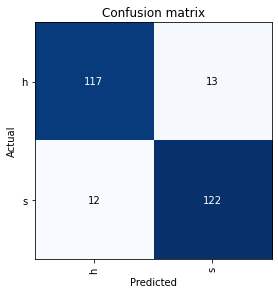

### **Conclusion**

In this journey, we took a dataset of Dell technical support emails and, using deep learning, classified them into 'hardware' and 'software' categories. With the power of pretrained models, tokenization, and gradual unfreezing, we achieved impressive results.

Unfortantly I can't share this specific dataset, but the full code is [here](https://github.com/c123ian/Dell_Language_Model_Project) on my GitHub.

Remember, deep learning is as much an art as it is a science. Keep experimenting, fine-tuning, and most importantly, have fun!

